- The resonant coefficients in this notebook are the wrong sign
  - Which is why the separatrix in FLI plots is shifted by $\pi$

# Preamble

In [1]:
%matplotlib widget

import os
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic
from scipy.special import hyp2f1
from sympy import init_printing, init_session

plt.style.use(analytic)
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val_outside = alpha0*f27lc(alpha0, 2)
f2val_outside = alpha0*f31lc(alpha0, 2)

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [2]:
import subprocess
def save_to_clipboard(dpi=300):
    plt.savefig("/tmp/clipboard.png", format="png", bbox_inches="tight", dpi=dpi)
    subprocess.run(
        [
            "osascript",
            "-e",
            f'set the clipboard to (read (POSIX file "/tmp/clipboard.png") as «class PNGf»)',
        ]
    )

# Equations

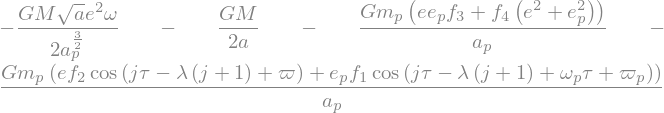

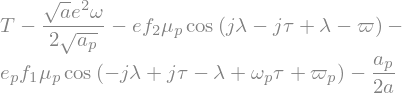

In [3]:
f1, f2, f3, f4, tau, l, pom, pom_p, g, om, om_p, T = sm.symbols(
    "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma omega omega_p T"
)
a, a_p, e, e_p, n, n_p, m_p, mu_p, L, G, Gconst, M, j = sm.symbols(
    "a a_p e e_p n n_p m_p mu_p Lambda Gamma G M j", positive=True
)
X, Y, Te, Tm = sm.symbols("X Y T_e T_m")

H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f2 * sm.cos((j + 1) * l - j * tau - pom)
        + e_p * f1 * sm.cos((j + 1) * l - j * tau - pom_p - om_p * tau)
    )
    - (Gconst * m_p / a_p * (f3 * e * e_p + f4 * (e**2 + e_p**2)))
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (
    (calH / H_scale_factor)
    .subs(m_p, mu_p * M)
    .simplify()
    .expand()
    .subs({f3: 0, f4: 0})
    #.subs(a, a * a_p)
) + T
display(calH)

In [6]:
print("beta=",f1val_outside)
print("beta_p=",-f2val_outside)

beta= -1.5455341716765871
beta_p= -1.8956507412695471


In [4]:
def to_canonical(expr):
    return expr.subs({a: L**2, e: sqrt(2 * G / L), pom: -g})


def to_orbelts(expr):
    # This uses the approximation G=1/2*L*e^2
    return expr.subs({g: -pom, G: Rational(1, 2) * L * e**2, L: sqrt(a)})

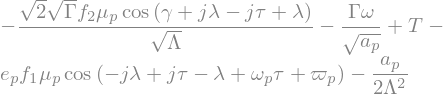

In [5]:
Hcanon = to_canonical(calH)
Hcanon

In [6]:
x = Matrix([tau,l,g,T,L,G])
x

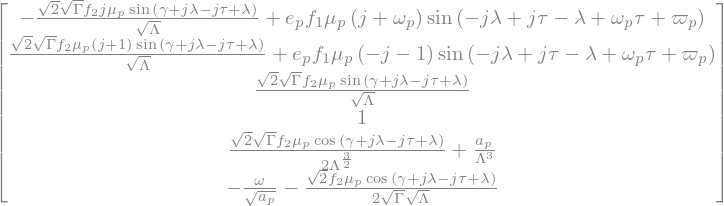

In [7]:
pHpx = Matrix([Hcanon]).jacobian(x).T
pHpx

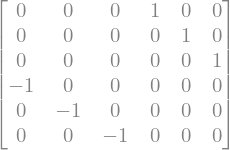

In [8]:
J = Matrix(BlockMatrix([[zeros(3,3),eye(3)],[-eye(3),zeros(3,3)]]))
J

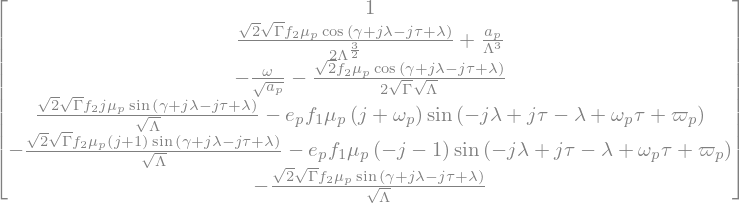

In [9]:
dxdt = J*pHpx
dxdt

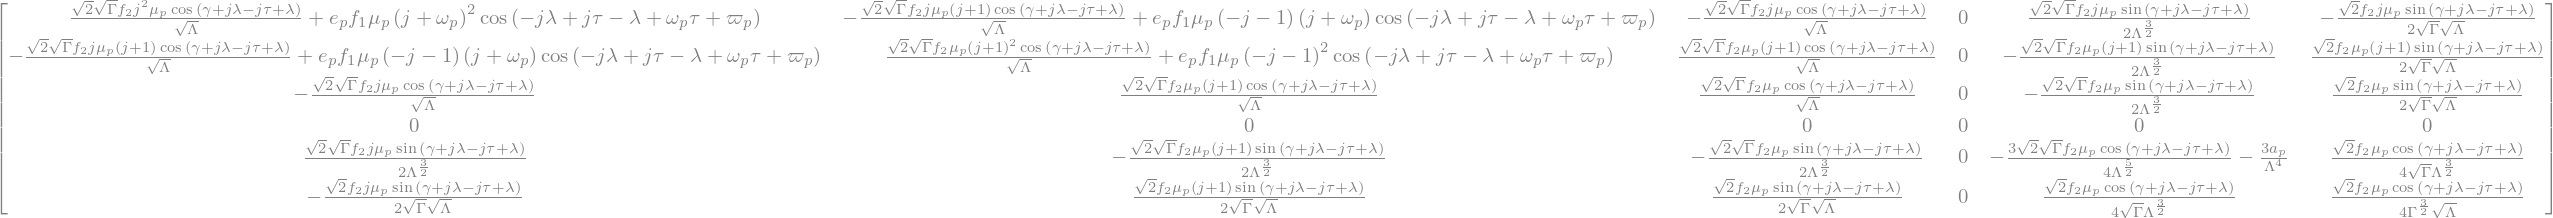

In [10]:
p2Hpx2 = pHpx.jacobian(x)
p2Hpx2

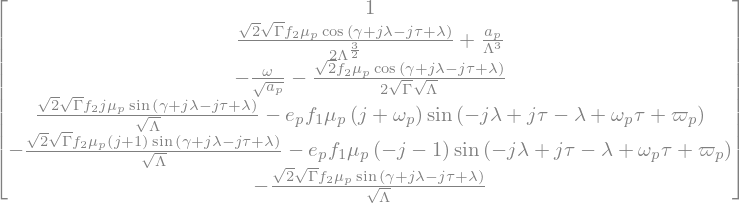

In [11]:
dxdt

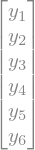

In [12]:
y1, y2, y3, y4, y5, y6 = sm.symbols("y_1 y_2 y_3 y_4 y_5 y_6")
y = Matrix([y1, y2, y3, y4, y5, y6])
y

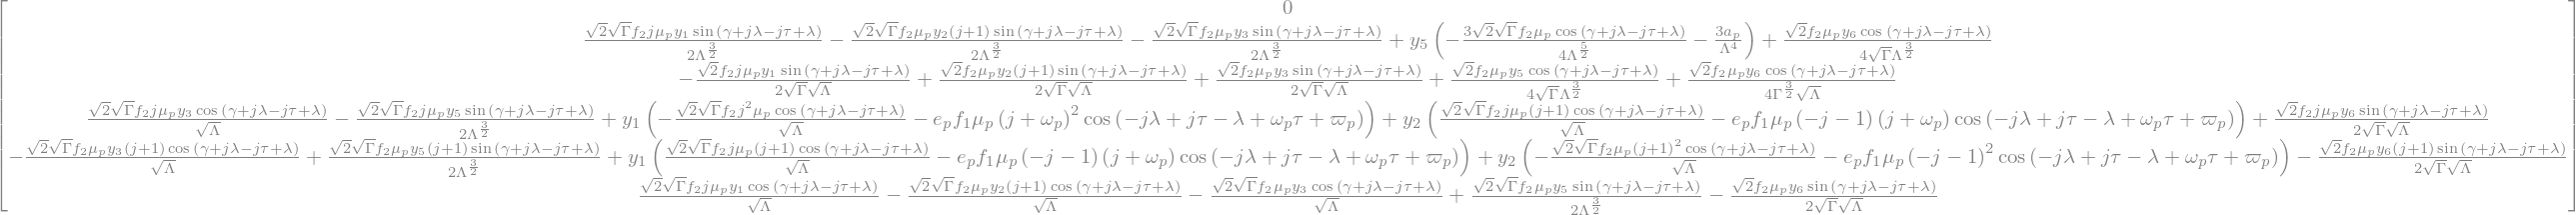

In [13]:
dydt = J*p2Hpx2*y
dydt

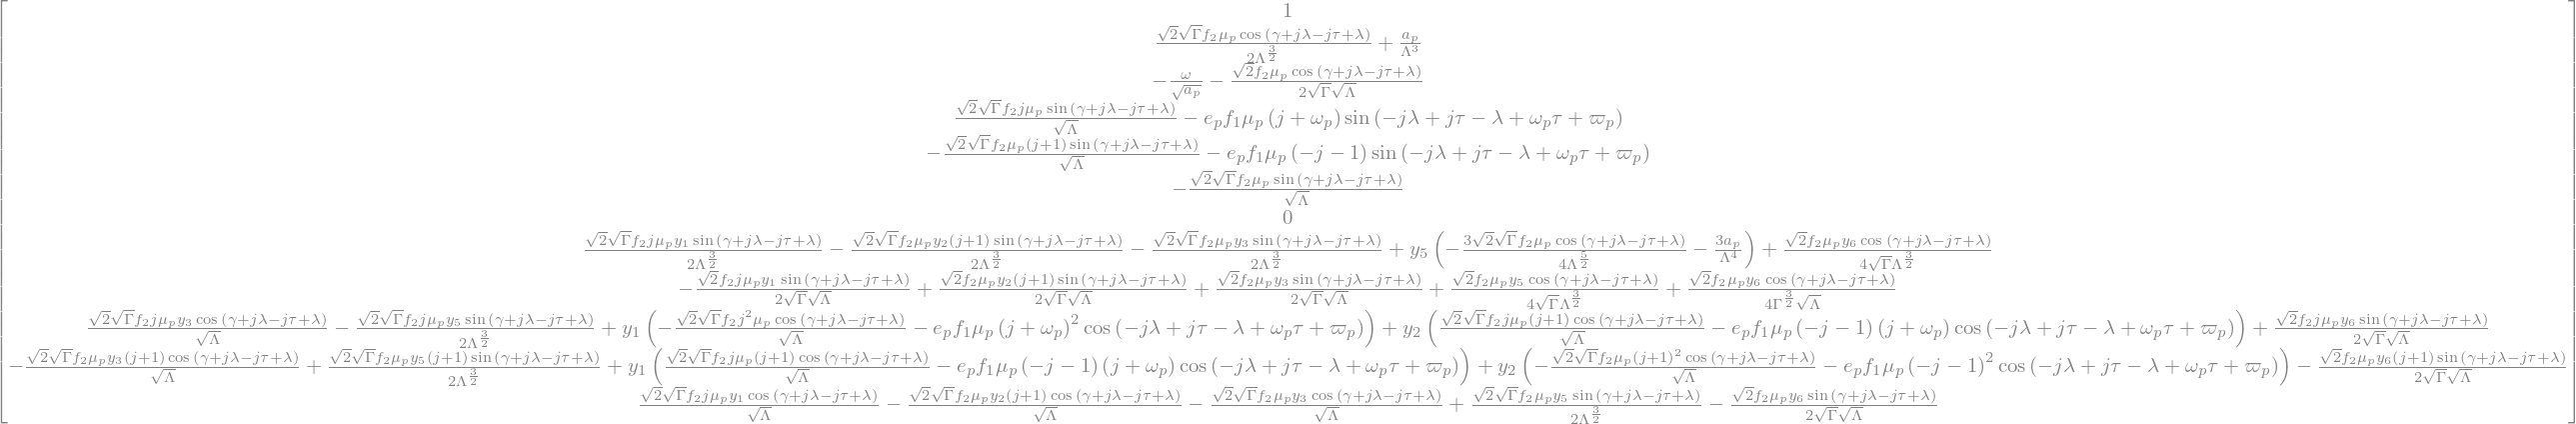

In [14]:
RHS = Matrix.vstack(dxdt, dydt)
RHS

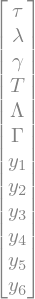

In [15]:
xy = Matrix.vstack(x,y)
xy

In [16]:
len(xy)

# Single runs

In [17]:
params = {
    a_p:1,
    e_p:0.1,
    mu_p:3e-6,
    pom_p:0,
    om:0,
    om_p:0,
    f1:f1val_outside,
    f2:f2val_outside,
    j:2,
}
rhs = RHS.subs(params)
rhs.free_symbols

In [18]:
rhs.free_symbols

In [19]:
rhsfunc = lambdify([t,*xy],rhs)

In [20]:
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]


In [21]:
initorb = {
    a:1.4,
    e:0.04,
    pom:0,
    l:np.pi/3
}
initcanon = {
    t:0,
    T:1,
    l:to_orbelts(l).subs(initorb),
    g:to_orbelts(g).subs(initorb),
    L:to_orbelts(L).subs(initorb),
    G:to_orbelts(G).subs(initorb),
    tau:0,
}
initcanon

In [22]:
rhsfunc

<function _lambdifygenerated(t, tau, lambda_, gamma, T, Lambda, Gamma, y_1, y_2, y_3, y_4, y_5, y_6)>

In [23]:
#inity = dxdt.subs(params).subs(initcanon).subs({}).evalf()
#inity = inity/sqrt((inity.T*inity)[0]) # normalize
inity = [0,0,0,1,0,0]
inity = {y[i]:el for i, el in enumerate(inity)}
inity

In [24]:
def func(t, Y):
    #return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7])[:,0]

    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]


Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]
Y0

array([0.00000000e+00, 1.04719755e+00, 0.00000000e+00, 1.00000000e+00,
       1.18321596e+00, 9.46572765e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [25]:
func(0,Y0)

array([ 1.00000000e+00,  6.03681514e-01,  1.20158797e-04, -5.78479459e-23,
        8.67719188e-23, -2.78580314e-23,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [26]:
#%%timeit
t_span = (0,100000)
sol = sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000))

In [27]:
dx_t = sol.y[6:,:]
dx_t.shape

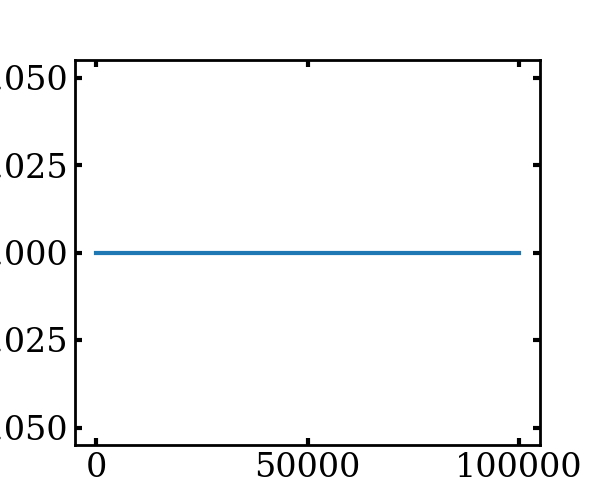

In [28]:
fig, ax = plt.subplots()
ax.plot(sol.t,np.log(np.linalg.norm(dx_t[:,:],axis=0)))

In [29]:
#%%timeit
sol = []
#for inity in [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]:
for inity in [[1,1,1,1,1,1]]:
    inity = {y[i]:el for i, el in enumerate(inity)}
    Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]

    t_span = (0,10000)
    sol += [sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000),rtol=1e-9)]

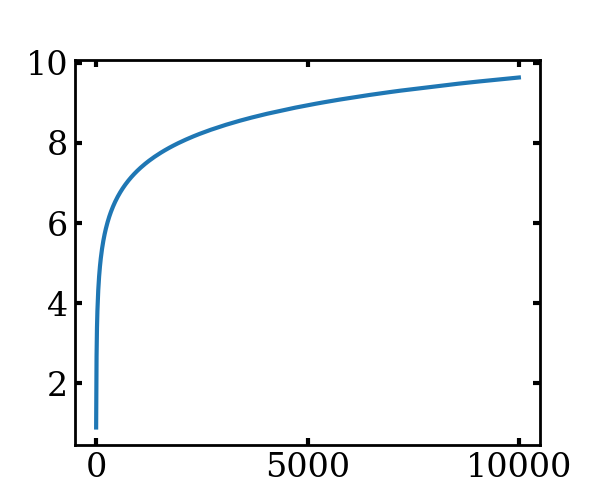

In [30]:
fig, ax = plt.subplots()
for s in sol:
    dx_t = s.y[6:,:]
    ax.plot(s.t,np.log(np.linalg.norm(dx_t[:,:],axis=0)))

# Grid of runs

In [185]:
params = {
    a_p:1,
    e_p:0.,
    mu_p:1e-3,
    pom_p:0.,
    om:0,
    om_p:0,
    f1:f1val_outside,
    f2:f2val_outside,
    j:2,
    "e0":0.01,
    "pom0":np.pi,
}
rhs = RHS.subs(params)
rhs.free_symbols
rhsfunc = lambdify([t,*xy],rhs)
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]

In [186]:
def calc_FLIt(p):
    i, av, th2v = p[0], p[1], p[2]
    print(i)
    initorb = {a: av, e: params["e0"], pom: params["pom0"]}
    initorb[l] =  (th2v-params["pom0"]) / (params[j] + 1)
    initcanon = {
        t: 0,
        T: 1,
        l: to_orbelts(l).subs(initorb),
        g: to_orbelts(g).subs(initorb),
        L: to_orbelts(L).subs(initorb),
        G: to_orbelts(G).subs(initorb),
        tau: 0,
    }

    avg_FLI = 0
    for inity in [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
    ]:
        inity = np.array(inity, dtype=np.float64)
        inity = {y[i]: el for i, el in enumerate(inity)}

        Y0 = np.float64(xy.subs(initcanon).subs(inity))[:, 0]
        t_span = (0, 1e3)
        sol = sp.integrate.solve_ivp(func, t_span, Y0)
        dx_t = sol.y[6:, :]
        avg_FLI += np.log10(np.linalg.norm(dx_t[:, :], axis=0)[-1])
    return avg_FLI / 6

In [187]:
(1.5)**(2./3)

In [188]:
N_side = 100
jobs = []
TH2V, AV = np.meshgrid(np.linspace(0, 2 * np.pi, N_side), np.linspace(1.24, 1.33, N_side))
for ii in range(len(TH2V.flatten())):
    jobs = jobs + [(ii, AV.flatten()[ii], TH2V.flatten()[ii])]

In [189]:
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle

In [193]:
executors_solve_ivp = get_reusable_executor(max_workers=16)
results = list(executors_solve_ivp.map(calc_FLIt, jobs))

0
1
2
4
3
5
7
6
8
9


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


12
13
10
11
14
15


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

16


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


17
18


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


19
20


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


21
22


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


23
24


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


25


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


26
27


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


28


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


29


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


30
31


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


32
33
34
35


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


36
37
38


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


39
40


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


41


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


42
43


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


44
45
46
47
48
49
50
51


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


52
53
54
55
56


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


57


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


58


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

59
60
61
62
63


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


64
65
66
67


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


68
69
70


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


71


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


72


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


73
74


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


75
76
77
78


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


79
80
81
82


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


83
84


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


85
86


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


87


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


88
89


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


90


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


91
92


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


93
94


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


95
96


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


97
98
99
100
101


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


102
103
104
105


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


106
107


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


108
109


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


110
111
112
113


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


114
115
116


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


117


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


118
119
120
121
122


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


123


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


124


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


125
126


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


127


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


128
129


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


130
131
132
133
134


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


135
136
137


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


138
139


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


140
141


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


142


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


143


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


144
145
146
147
148
149
150
151
152
153


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


154
155
156
157
158


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


159


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

160
161
162
163


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


164
165
166
167
168


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


169
170
171


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


172
173
174
175


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


176
177
178
179
180


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


181
182
183
184


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


185
186


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


187
188
189
190


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


191


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


192
193
194


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


195
196
197
198
199
200


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


201
202


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


203
204


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


205
206


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


207
208


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

209
210
211
212


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


213
214
215
216


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


217
218
219


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


220
221


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


222
223


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


224
225
226


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


227


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


228


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


229


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


230
231
232


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


233
234
235
236
237
238
239


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


240


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


241
242
243


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


244
245
246
247
248
249
251
250
252
253


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


254


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


255
256
257
258


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


259


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


260
261
262


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

263
264
265
266
267
268


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


269
270
271


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


272
273
274
275


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


276
277
278
279


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


280
281
282


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


283
284


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


285
286
287


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


288
289
290


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


291


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


292


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


293
294


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


295
296


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


297
298
299
300
301
302


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


303


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


304
305


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


306
307
308
309


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


310
311
312
313
314


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

315
316


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


317
318


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


319
320


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


321
322


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


323
324


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


325


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


326
327


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


328


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


329


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


330


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


331
332
333
334


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


335
336
337


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


338
339
340


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


341
342
343


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


344
345
346
347
348
349
350
351
352


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


353
354
355
356
357
358


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


359


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

360
361
362
363


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


364
365
366
367
368
369


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


370
371
372


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


373
374


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


375
376
377


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


378
379
380


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


381
382


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


383
384
385


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


386


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


387
388


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


389
390
391


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


392


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


393
394
395
396


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


397
398
399
400
401
402
403


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


404


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


405
406
407


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


408
409
410
411


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


412
413
414
415
416


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

417


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


418
419


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


420
421
422


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


423
424


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


425
426


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


427


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


428


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


429


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


430


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


431
432
433
434


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


435
436


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


437
438
439


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


440
441


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


442


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


443
444
445


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


446
447
448
449
450
451
452
453
454
455
456


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


457
458


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


459
460
461


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


462
463
464
465


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


466
467
468
469
470


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

471
472
473
474


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


475
476


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


477
478


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


479
480
481


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


482
483


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


484
485
486


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


487
488


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


489
490
491


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


492
493


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


494
495
496
497
498


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


499
500
501
502
503
504


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


505
506


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


507
508


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


509
510
511


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


512


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

513
514
515
516
517
518


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


519
520


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


521


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


522
523
524


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


525


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


526
527


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


528


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


529


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


530
531
532
533


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


534
535
536
537


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


538
539
540


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


541


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


542
543
544


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


545
546
547
548
549
550


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


551
552
553
554
555
556


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

557
558
559


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


560
561
562


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


563
564
565
566
567
568
569


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invali

570
571


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


572
573
574


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


575


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


576
577


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


578
579
580


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


581
582
583
584


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


585
586


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


587


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


588
589
590


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


591


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


592


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


593
594


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


595
596
597
598


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


599
600
601
602


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


603
604


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


605
606
607


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


608
609
610
611
612
613


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

614


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


615
616
617


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


618
619


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


620
621
622


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


623
624
625
626


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


627
628


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


629


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


630


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


631
632


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


633
634


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


635
636
637
638
639
640


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


641
642


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


643
644


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


645
646
647


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


648
649
650
651
652
653
654
655
656


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


657


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


658
659


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


660
661
662
663


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


664
665
666


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


667
668
669
670
671
672


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


673


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


674
675
676


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


677
678


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


679
680


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


681
682
683
684
685


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


686
687


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


688


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


689
690


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


691


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


692
693
694
695


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


696
697
698


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


699
700
701
702
703


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


704
705


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


706
707


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


708


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


709
710
711


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

712
713
714
715


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


716


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


717
718
719
720


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


721
722


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


723


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


724
725


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


726
727


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


728


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


729


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


730


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


731
732
733


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


734


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


735


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


736


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


737


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


738


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


739
740


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


741
742


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


743
744


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


745
746
747
748
749
750
751


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


752
753


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


754
755
756


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


757
758


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


759


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


760
761
762
763
764
765


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


766
767
768


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


769


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


770
771


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


772
773
774


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


775


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


776
777


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


778
779
780
781
782


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


783
784
785


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


786
787


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


788
789


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


790
791


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


792
793
794


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


795
796
797
798
799
800
801


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


802
803
804
805


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


806


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


807
808


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


809
810
811
812
813
814


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

815
816
817


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


818
819
820
821


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


822


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


823


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


824
825
826
827


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


828
829
830


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


831


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


832
833
834


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


835
836


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


837


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


838
839
840


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


841


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


842


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


843
844


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


845
846


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


847
848
849


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


850
851
852
853


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


854
855
856


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


857


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


858


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


859


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


860


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


861


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


862


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


863


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


864
865


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


866
867


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


868
869
870


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


871


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


872


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


873


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


874


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


875


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


876


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


877


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


878


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


879


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


880
881


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


882
883


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


884
885


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


886


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


887
888


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


889


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


890
891


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


892
893
894
895
896


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


897


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


898
899
900


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


901
902


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


903


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


904


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


905
906


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


907
908
909
910


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


911


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


912
913


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


914


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


915


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


916


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


917


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


918
919
920
921


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


922
923


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


924


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


925
926
927


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


928
929


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


930


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


931
932
933
934


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


935
936


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


937
938
939
940
941
942


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


943


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


944


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


945
946
947


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


948
949
950
951
952
953


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


954


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


955


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


956
957
958


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


959


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


960


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


961
962


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


963


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


964


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


965


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


966
967
968
969


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


970


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


971


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


972


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


973


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


974


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


975


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


976


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


977


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


978
979


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


980


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


981


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


982


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


983


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


984


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


985


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


986


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


987
988
989
990


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


991


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


992


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


993


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


994
995
996
997
998
999
1000
1001
1002


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1003
1004


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1005


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1006
1007
1008
1009


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1010
1011
1012
1013
1014
1015


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1016
1017


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1018
1019


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1020


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1021


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1022
1023
1024
1025


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1026


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1027
1028


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1029


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1030


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1031


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1032
1033
1034


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1035
1036
1037
1038
1039


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1040
1041
1042


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1043
1044


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1045


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1058


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1059
1060


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1061
1062
1063
1064
1065
1066


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1067
1068
1069
1070
1071
1072
1073


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1074
1075
1076


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1077


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1078
1079
1080


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1081
1082
1083
1084
1085


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1086


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1087
1088
1089


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1090
1091


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1092


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1093


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1094
1095
1096
1097
1098
1099
1100
1101
1102
1103


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1104
1105


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1106
1107
1108
1109
1110
1111
1112


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1113
1114
1115


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1116
1117
1118
1119


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1120


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1121
1122
1123
1124
1125
1126
1127
1128


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1129


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1130


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1131


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1132
1133


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1134
1135
1136
1137
1138


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1139
1140
1141


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1142
1143
1144


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1145


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1146
1147
1148
1149
1150
1151
1152
1153


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1154
1155
1156
1157
1158


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1159
1160


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1161
1162
1163
1164
1165
1166
1167
1168


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1169
1170
1171
1172
1173
1174
1175


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1176


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1177


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1178
1179
1180


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1181
1182
1183
1184


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1185
1186
1187


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1188
1189


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1190


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1191


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1192


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1193
1194
1195
1196
1197


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1198
1199
1200
1201


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1202
1203
1204
1205


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1206
1207
1208
1209
1210
1211


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1212
1213
1214


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1215
1216
1217


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1218
1219
1220
1221


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1222
1223
1224


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1225
1226


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1227
1228


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1229


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1230


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1231
1232
1233


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1234
1235
1236


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1237
1238
1239
1240


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1241


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1242


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1243
1244


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1245
1246
1247
1248
1249
1250


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1251
1252
1253
1254
1255


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1256
1257


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1258
1259


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1260
1261
1262


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1263
1264
1265
1266


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1267
1268
1269
1270


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1271
1272


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1273
1274
1275


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1276


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1277
1278


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1279
1280
1281
1282


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1283
1284


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1285
1286
1287


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1288
1289


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1290
1291


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1292


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1293
1294
1295
1296
1297


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1298
1299


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1300
1301
1302


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1303
1304


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1305
1306
1307
1308
1309
1310
1311


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1312
1313
1314


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1315
1316
1317
1318
1319


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1320
1321
1322
1323


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1324
1325
1326


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1327
1328


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1329


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1330


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1331
1332


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1333
1334
1335
1336
1337


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1338
1339
1340
1341


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1342
1343


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1344
1345


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1346
1347
1348


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1349
1350
1351
1352


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1353
1354
1355


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1356
1357


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1358
1359


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1360
1361


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1362
1363
1364


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1365
1366
1367
1368


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1369
1370
1371
1372


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1373


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1374
1375


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1376
1377


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1378
1380
1379


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1381
1382
1383
1384


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1385
1386
1387


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1388


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1389


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1390
1391


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1392


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1393


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1394
1395
1396
1397
1398
1399
1400
1401


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1402
1403


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1404
1405
1406


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1407
1408


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1409
1410
1411
1412


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1413
1414
1415
1416
1417


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1418


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1419
1420
1421
1422


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1423
1424


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1425
1426
1427


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1428


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1429
1430


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1431


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1432
1433
1434
1435
1436


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1437
1438
1439
1440


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1441
1442
1443


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1444
1445


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1446
1447
1448
1449
1450


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1451
1452
1453
1454
1455


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1456
1457
1458


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1459
1460
1461
1462


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1463
1464
1465


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1466
1467
1468
1469
1470


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1471
1472
1473


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1474
1475


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1476
1477
1478


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1479
1480
1481


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1482
1483
1484


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1485
1486
1487


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1488
1489


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1490


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1491


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1492


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1493


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1494
1495
1496
1497
1498
1499
1500
1501
1502


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1503
1504


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1505


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1506
1507
1508
1509
1510


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1511
1512
1513
1514


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1515
1516
1517
1518
1519


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1520


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1521
1522
1523
1524
1525


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1526
1527


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1528
1529


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1530
1531


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1532
1533
1534
1535
1536


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1537
1538
1539
1540
1541
1542
1543
1544


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1545
1546


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1548
1547
1549
1550
1551
1552
1553


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1554
1555
1556
1557
1558
1559


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1560
1561


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1562
1563
1564
1565
1566
1567
1568
1569
1570


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1571
1572
1573


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1574
1575
1576
1577


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1578


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1579
1580


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1581
1582
1583
1584


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1585
1586


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1587
1588


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1589
1590


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1591
1592


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1593


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1594
1595
1596
1597
1598
1599


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1600
1601


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1602
1603
1604
1605


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1606


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1607
1608
1609
1610
1611
1612


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1613
1614
1615
1616


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1617
1618
1619
1620


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1621


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1622
1623
1624


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1625
1626
1627


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1628


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1629


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1630
1631


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1632


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1633
1634
1635
1636


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1637
1638
1639
1640


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1641
1642
1643


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1644
1645


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1646
1647
1648
1649
1650
1651
1652
1653
1654


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1655
1656


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1657
1658
1659


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1660
1661
1662


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1663
1664
1665
1666
1667


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1668
1669
1670
1671
1672
1673


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1674
1675


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1676


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1677
1678


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1679
1680
1681


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1682
1683


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1684
1685
1686
1687


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1688
1689


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1690
1691
1692


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1693
1694
1695
1696
1697
1698
1699
1700


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1701
1702


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1703
1704
1705


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1706
1707
1708
1709
1710
1711
1712
1713
1714
1715


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1716
1717


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1718
1719
1720


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1721
1722
1723
1724


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1725
1726


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1727
1728


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1729


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1730
1731


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1732
1733
1734


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1735
1736
1737
1738


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1739


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1740
1741


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1742
1743


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1744
1745


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1746
1747
1748
1749
1750
1751


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1752
1753
1754
1755


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1756
1757
1758
1759


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1760


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1761
1762
1763


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1764
1765
1766
1767
1768
1769


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1770
1771


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1772
1773
1774
1775


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1776


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1777
1778


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1779
1780
1781


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1782
1783
1784
1785


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1786
1787


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1788
1789
1790


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1791


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1792


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1793
1794
1795
1796
1797
1798


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1799
1800
1801
1802
1803
1804


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1805


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1806
1807
1808
1809
1810
1811
1812
1813


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1814
1815
1816
1817


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1818
1819


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1820


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1821
1822
1823


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1824
1825
1826


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1827
1828


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1829


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1830


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1831


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1832
1833
1834
1835


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1836
1837
1838
1839
1840
1841
1842


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1843
1844


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1845


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1846
1847
1848
1849
1850
1851
1852
1853
1854
1855


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1856
1857


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1858
1859
1860


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1861


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1862
1863
1864


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1865
1866
1867
1868
1869
1870
1871


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1872
1873
1874
1875


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1876
1877


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1878
1879
1880


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1881
1882


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1883
1884
1885
1886


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1887
1888


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1889
1890


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1891


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1892


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1893
1894
1895
1896
1897
1898
1899
1900


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1901
1902


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1903


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1904
1905
1906
1907


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1908
1909
1910


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1911
1912
1914
1913
1915


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1916
1917
1918
1919
1920


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1921
1922
1923


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1924
1925
1926
1927


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1928


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1929


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1930
1931


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1932
1933
1934
1935


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1936
1937
1938
1939


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1940
1941
1942


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1943
1944
1945


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1946
1947
1948
1949
1950
1951


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1952
1953
1954
1955
1956


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1957
1958


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1959
1960


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1961
1962
1963
1964
1965
1966


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

1967
1968
1969


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1970
1971
1972
1973
1974
1975
1976


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1977


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1978
1979
1980


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1981
1982
1983


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1984
1985


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1986
1987
1988
1989


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1990


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1991


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1992


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1993
1994
1995
1996


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


1997
1998
1999
2000
2001


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2002
2003


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2004
2005
2006
2007


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2008
2009
2010
2011
2012


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2013
2014
2015
2016


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2017
2018


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2019
2020
2021
2022


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2023
2024
2025
2026


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2027
2028


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2029
2030


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2031


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2032
2033
2034


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2035
2036
2037


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2038
2039


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2040


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2041
2042
2043


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2044
2045


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2046
2047
2048
2049
2050


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


20512052
2053

2054
2055


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2056
2057
2058


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2059
2060
2061


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2062
2063


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2064
2065
2066
2067
2068
2069


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2070
2071


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2072
2073
2074
2075


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2076
2077
2078


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2079
2080


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2081
2082
2083


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2084
2085
2086
2087


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2088
2089


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2090


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2091
2092


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2093
2094
2095
2096


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2097
2098
2099


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2100
2101
2102
2103


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2104
2105
2106
2107


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2108
2109
2110


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2111
2112
2113


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2114
2115


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2116
2117
2118


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2119
2120
2121


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2122
2123
2124
2125
2126


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2127
2128
2129


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2130


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2131


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2132
2133
2134


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2135
2136
2137
2138
2139
2140


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2141
2142


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2143
2144
2145


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2146
2147
2148
2149


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2150
2151
2152
2153
2154
2155


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2156
2157


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2158
2159
2160
2161


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2162
2163
2164


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2165
2166
2168
2167
2169


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2170
2171
2172


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2173
2174
2175


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2176
2177
2178


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2179
2180
2181


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2182
2183
2184
2185
2186


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2187


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2188
2189


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2190


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2191
2192
2193


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2194
2195
2196
2197


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2198
2199
2200


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2201
2202
2203
2204
2205


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2206
2207
2208
2209
2210
2211
2212
2213
2214


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2215
2216
2217


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2218
2219
2220


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2221
2222
2223
2224
2225
2226
2227
2228


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2229
2230


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2231


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2232


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2233
2234
2235
2236
2237


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2238
2239


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2240
2241
2242


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2243


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2244
2245
2246


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2247
2248
2249
2250


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2251
2252
2253
2254
2255
2256


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2257


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2258
2259


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2260
2261
2262


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2263
2264
2265
2266
2267


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2268
2269
2270
2271


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2272
2273


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2274
2275
2276
2277


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2278
2279
2280
2281


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2282
2283
2284


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2285
2286


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2287
2288


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2289
2290


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2291
2292


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2293
2294
2295
2296
2297


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2298
2299
2300
2301
2302


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2303
2304
2305


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2306
2307


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2308
2309
2310
2311
2312
2313


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2314


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2315
2316
2317


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2318
2319


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2320
2321


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2322
2323
2324
2325


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2326
2327


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2328
2329


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2330
2331


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2332
2333
2334


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2335
2336
2337
2338
2339


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2340
2341
2342


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2343


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2344
2345


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2346
2347
2348
2349
2350
2351


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2352
2353


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2354
2355
2356
2357
2358


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2359
2360


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2361
2362
2363


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2364
2365
2366
2367


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2368
2369
2370
2371


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2372
2373


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2374


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2375
2376


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2377
2378
2379


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2380
2381
2382


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2383
2384
2385
2386


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2387
2388
2389


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2390
2391


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2392
2393
2394
2395
2396
2397


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2398
2399


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2400
2401
2402
2403
2404


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2405
2406
2407
2408
2409


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2410
2411
2412
2413
2414


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2415
2416
2417
2418


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2419


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2420
2421
2422
2423


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2424
2425


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2426
2427


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2428


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2429


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2430
2431
2432


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2433
2434
2435


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2436
2437
2438
2439
2440


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2441
2442
2443


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2444
2445
2446
2447
2448
2449
2450
2451
2452


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2453
2454
2455
2456


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2457
2458
2459


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2460


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2461
2462
2463
2464
2465
2466
2467
2468


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2469
2470
2471


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2472
2473
2474


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2475
2476


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2477
2478
2479
2480


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2481
2482
2483
2484


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2485
2486


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2487
2488


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2489
2490


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2491


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2492
2493
2494
2495
2496


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2497
2498
2499


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2500
2501
2502
2503
2504


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2505
2506
2507
2508
2509
2510
2511
2512
2513


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2514
2515


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2516
2517
2518
2519


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2520
2521
2522
2523
2524
2525


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2526
2527


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2528
2529


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2530


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2531


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2532


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2533
2534
2535


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2537
2538
2536
2539
2540


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2541
2542
2543
2544
2545


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2546
2547


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2548
2549
2550
2551
2552
2553
2554


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2555
2556
2557
2558


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2559
2560


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2561


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2562
2563
2564


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2565
2566
2567
2568
2569
2570
2571
2572
2573


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2574
2575
2576


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2577
2578


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2579
2580
2581
2582
2583
2584
2585


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2586
2587


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2588
2589


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2590
2591


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2592


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2593
2594
2595
2596
2597
2598
2599


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2600
2601
2602
2603
2604


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2605


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2606
2607
2608
2609
2610


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2611
2612
2613
2614


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2615
2616
2617
2618
2619


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2620
2621
2622
2623
2624


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2625
2626
2627
2628
2629


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2630


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2631


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2632


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2633


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2634
2635
2636
2637


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2638
2639
2640
2641
2642
2643


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2644


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2645
2646
2647


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2648
2649
2650
2651
2652
2653


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2654
2655
2656
2657
2658
2659


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2660
2661
2662


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2663
2664


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2665
2666
2667
2668


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2670
2669
2671
2672
2673
2674


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2675
2676


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2677
2678


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


2679
2680


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2681
2682
2683


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2684
2685
2686


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2687
2688
2689


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2690


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2691


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2692


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2693
2694
2695
2696
2697
2698


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2699
2700
2701
2702


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2703
2704


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2705


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2706
2707
2708
2709
2710
2711
2712
2713
2714
2715


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2716
2717
2718
2719


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2720
2721


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2722
2723
2724


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2725
2727
2726


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2728


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2729
2730


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2731


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2732


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2733
2734
2735
2736
2737


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2738
2739
2740
2741
2742
2743


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2744
2745


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2746
2747


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2748
2749
2750
2751


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2752
2753
2754
2755
2756
2757
2758
2759
2760
2761


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2762
2763


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2764
2765
2766
2767


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2768
2769
2770
2771
2772
2773
2774


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2775
2776
2777


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2778


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2779
2780


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2781
2782
2783
2784
2785


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2786
2787
2788
2789


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2790
2791


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2792
2793
2794
2795
2796
2797


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2798
2799
2800


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2801
2802
2803
2804


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2805
2806
2807
2808
2809
2810
2811


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2812
2813


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2814
2815
2816
2817
2818


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2819
2820
2821


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2822
2823
2824
2825
2826
2827


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2828


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2829


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2830
2831


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2832


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2833


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2834
2835
2836
2837


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2839
2838
2840
2841


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2842
2843


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2844
2845
2846


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2847
2848
2849


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2850
2851
2852
2853
2854
2855
2856


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2857
2858
2859


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2860
2861


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2862
2863


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2864
2865
2866
2867
2868


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2869
2870
2871
2872
2873


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2874
2875
2876
2877


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2878


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2879
2880


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2881
2882
2883


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2884
2885
2886
2887


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2888
2889
2890


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2891


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2892
2893
2894


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2895
2896
2897
2898
2899


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2900
2901


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2902
2903
2904
2905


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2917
2918
2919
2920


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2921
2922


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2923
2924
2925


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2926
2927
2928


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2929
2930


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2931
2932


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2933
2934
2935
2936
2937
2938


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2939
2940
2941


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2942
2943
2944


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2945


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2946
2947
2948
2949
2950


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

2951
2952
2953
2954
2955
2956


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2957
2958
2959
2960


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2961
2962
2963
2964


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2965
2966
2967
2968


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2969
2970
2971


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2972
2973
2974
2975
2976


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2977


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2978
2979


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2980
2981
2982
2983


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2984
2985
2986


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2987
2988
2989


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2990


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2991
2992
2993
2994
2995
2996
2997
2998


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


2999
3000
3001
3002


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3003


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3004
3005


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3006
3007
3008
3009
3010
3011
3012
3013
3014


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3015
3016
3017
3018


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3019
3020


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3021


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3022
3023
3024
3025


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3026
3027


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3028
3029
3030


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3031


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3032
3033


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3034
3035
3036
3037
3038
3039
3040
3041


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3042
3043


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3044
3045
3046
3047
3048


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3049
3050
3051
3052
3053
3054


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3055
3056
3057


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3058
3059


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3060
3061
3062


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3063
3064
3065
3066
3067
3068
3069
3070


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3071
3072
3073
3074
3075


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3076
3077
3078


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3079
3080
3081
3082
3083
3084


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3085


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3086
3087
3088
3089


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3090
3091


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3092
3093
3094
3095
3096


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3097
3098
3099


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3100
3101
3102
3103


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3104
3105
3106
3107
3108
3109
3110


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3111
3112
3113
3114


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3115
3116
3117
3118


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3119
3120


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3121
3122
3123
3124
3125


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3126
3127
3128


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3129


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3130


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3131
3132


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3133


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3134
3135
3136
3137
3138
3139
3140


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3141
3142


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3143


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3144
3145
3146


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3147
3148
3149
3150
3151


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3152
3153
3154
3155


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3156
3157
3158


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3159
3160
3161


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3162
3163
3164
3165
3166
3167


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3168
3169
3170
3171


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3172
3173
3174


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3175
3176
3177
3178


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3179
3180
3181
3182


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3183
3184
3185


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3186
3187
3188
3189


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3190


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3191


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3192
3193
3194
3195
3196
3197


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3198
3199
3200
3201


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3202
3203
3204


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3205
3206
3207
3208
3209
3210
3212
3211
3214
3213
3215


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3216


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3217
3218
3219
3220
3221
3222


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3223
3224
3225
3226


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3227
3228


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3229
3230
3231


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3232


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3233


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3234
3235
3236
3237
3238
3239


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3240
3241
3242
3243


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3244
3245


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3246
3247
3248
3249
3250


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3251
3252
3253
3254
3255
3256
3257


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3258
3259
3260


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3261


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3273
3274
3275


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3276


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3277
3278


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3279
3280
3281
3282
3283
3284


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3285
3286
3287


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3288
3289


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3290
3291


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3292


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3293
3294
3295
3296
3297
3298
3299


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3300
3301
3302


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3303
3304
3305
3306
3307
3308
3309
3310


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3311
3312
3313
3314


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3315
3316
3317
3318


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3319


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3320
3321
3322


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3323
3324
3325
3326
3327


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3328


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3329


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3330


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


3331


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3332
3333


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3334
3335
3336
3337
3338


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3339
3340
3341
3342
3343


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3344
3345


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3346
3347
3348


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3349
3350
3351
3352
3353
3354


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3355
3356
3357
3358


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3359
3360
3361
3362


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3363
3364
3365
3366


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3367
3368
3369
3370
3371


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3372
3373
3374
3375
3376


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3377
3378


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3379
3380
3381


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3382
3383


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3384
3385
3386
3387


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3388
3389
3390


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3391


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3392


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3393
3394
3395
3396
3397


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3398
3399
3400


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3401
3402
3403
3404
3405


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3406
3407


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3408
3409
3410
3411
3412
3413
3414


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3415
3416


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3417
3418
3419


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3420
3421


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3422
3423
3424
3425


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3426
3427
3428


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3429
3430
3431
3432


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3433


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3434
3435
3436
3437


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3438
3439
3440
3441
3442
3443
3444


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3445
3446


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3447
3448
3449


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3450
3451
3452
3453
3454
3455
3456
3457


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3458
3459
3460
3461


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3462


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3463
3464


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3465
3466
3467
3468
3469


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3470
3471
3472
3473
3474
3475


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3476
3477


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3478


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3479
3480


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3481
3482
3483


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3484
3485
3486


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3487
3488
3489
3490


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3491
3492


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3493
3494
3495
3496
3497
3498
3499


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3500
3501
3502
3503
3504


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3516
3517
3518


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3519
3520


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3521
3522
3523


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3524
3525
3526
3527
3528
3529


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3530
3531


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3532
3533


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3534
3535
3536
3537
3538
3539
3540


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3541
3542
3543
3544
3545


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3546
3547
3548
3549
3550
3551
3552
3553


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3554
3555
3556
3557
3558
3559
3560
3561


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3562
3563


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3564
3565
3566
3567
3568
3569


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3570
3571
3572
3573
3574
3575
3576


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3577


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3578
3579


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3580
3581
3582
3584
3583
3585
3586
3587


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3588
3589
3590
3591


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3592
3593
3594
3595


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3596
3597
3598
3599
3600
3601
3602


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3603


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3604
3605


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


3618


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

3619
3620
3621
3622


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3623
3624
3625
3626


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3627
3628


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3629
3630
3631


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3632
3633


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3634


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3635
3636
3637


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3638
3639
3640
3641
3642
3643


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3644
3645
3646


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3647


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3648
3649
3650
3651


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3652
3653
3654
3655
3656
3657
3658
3659


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3660
3661
3662


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3663


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3664
3665


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3666
3667
3668
3669
3670
3671


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3672
3673
3674
3675
3676
3677
3678


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3679


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3680
3681
3682


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3683
3684
3685


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3687
3686
3688
3689


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3690
3691


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3692
3693
3695
3696
3694
3697
3698
3699
3700


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3701
3702


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3703
3704
3705
3706
3707


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3708
3709
3710
3711
3712
3713
3714


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3715
3716
3717
3718
3719
3720
3721


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3722
3723
3724
3725
3726
3727


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3728
3729


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3730
3731


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3732


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3744
3745


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3746
3747
3748


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3749
3750
3751
3752
3753
3754
3755
3756
3757


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3758
3759
3760
3761


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3762
3763
3764


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3765
3766


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3767
3768
3769
3770
3771


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3772
3773


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3774
3775
3776
3777


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3778
3779


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3780
3781
3782


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3783
3784


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3785
3786


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3787
3788
3789
3790
3791


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3792


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3793
3794
3795
3796
3797
3798


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3799
3800
3801
3802
3803


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3804
3805
3806


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3807
3808
3809
3810
3811
3812
3813
3814


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3815
3816
3817
3818


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3819
3820


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3821
3822
3823
3824
3825
3826
3827
3828


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3829
3830


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3831


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3832


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3833
3834


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3835
3836
3837
3838


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3839
3840
3841
3842
3843
3844
3845
3846


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3847
3848
3849


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3850
3851
3852
3853
3854
3855


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3856
3857
3858
3859
3860
3861


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3862
3863
3864
3865


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3866
3867
3868
3869


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3870
3871
3872
3873
3874


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3875
3876
3877
3878
3879
3880
3881


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3882
3883


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3884
3885


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3886
3887
3888
3889


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3890


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3891
3892


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3893
3894
3895
3896
3897
3898
3899


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3900
3901
3902
3903
3904


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3905
3906
3907


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3908
3909
3910
3911
3912
3913
3914
3915


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3916
3917
3918
3919
3920


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3921
3922
3923
3924
3925
3926
3927


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3928
3929
3930
3931
3932


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3933


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3934


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3935
3936


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3937
3938
3939
3940
3941
3942
3943


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3944
3945
3946
3947


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3948
3949


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3950
3951
3952
3953
3954
3955


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3956
3957
3958
3959


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3960
3961
3962
3963
3964


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3965
3966
3967
3968
3969
3970
3971
3972


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

3973
3974
3975
3976
3977
3978
3979


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3980
3981


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3982
3983
3984


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3985
3986
3987
3988


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3989
3990


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3991


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


3992
3993
3994
3995
3996
3997
39983999
4000



<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4001
4002
4003
4004


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4017
4018
4019
4020
4021


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4022
4023
4024
4025
4026
4027
4028


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4029
4030
4031


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4032
4033


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4034
4035
4036


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4037
4038
4039


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4040
4041
4042
4043
4044
4045
4046


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4047
4048
4049
4050
4051
4052
4053
4054
4055


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4056
4057
4059
4058
4060
4061


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4062
4063


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4064
4065
4066
4067
4068


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4069
4070
4071


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4072
4073
4074
4075


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4076
4077


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4078
4079


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4080
4081
4082
4083
4084


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4085
4086


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4087
4088
4089
4090


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4091
4092
4093
4094


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4095
4096
4097
4098


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4099
4100
4101
4102


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4103
4104


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4105
4106
4107
4108
4109


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4110
4111


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4112
4113
4114


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4115
4116
4117
4118
4119
4120


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4121
4122
4123
4124
4125
4126


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4127
4128
4129


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4130


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4131
4132


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4133
4134


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4135
4136


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


4137
4138
4140
4139
4141
4142
4143


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

4144
4145
4146


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4147
4148
4149


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4150
4151
4152
4153
4154
4155
4156
4157


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4158
4159
4160
4161


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4162
4163
4164
4165
4166


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4167
4168
4169
4170
4171
4172
4173


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4174
4175
4176


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4177
4178
4179


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4180
4181
4182
4183


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4184
4185
4186
4187


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4188
4189
4190


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4191
4192
4193
4194
4195


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4196
4197
4198
4199


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4200
4201
4202
4203


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4204
4205
4206
4207
4208
4209


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4210
4211
4212
4213
4214
4215
4216


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4217
4218
4219


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4220
4221
4222
4223
4224
4225


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4226


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4227
4228
4229
4230


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4231
4232


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4233


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4234


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4235
4236
4237
4238
4239
4240
4241
4242
4243
4244


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4245
4246
4247


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4248
4249
4250
4251
4252
4253


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4254
4255
4256
4257


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4258
4259
4260
4261
4262


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4263
4264
4265
4266
4267
4268


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4269
4270
4271
4272


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4273
4274
4275
4276
4277


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4278
4279


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4280
4281
4282
4283
4284


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4285
4286


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4287
4288


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4289
4290
4291
4292
4293
4294
4295


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4296
4297
4298
4299
4300


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4301
4302
4303
4304
4305


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4306
4307
4308
4309
4310
4311


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4312
4313
4314
4315
4316
4317


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4318
4319
4320


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4321
4322
4323
4324
4325


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4326
4327
4328


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4329
4330


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4331
4332


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4333


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4334
4335
4336


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4337
4338
4339
4340
4341
4342
4343
4344


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4345
4346
4347
4348


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4349
4350
4351
4352
4353
4354
4355


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4356
4357
4358
4359
4360


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4361
4362
4363
4364


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4365
4366
4367
4368
4369
4370
4371
4372


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4373
4374
4375
4376


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4377
4378
4379
4380
4381


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4382


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4383
4384
4385
4386


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4387
4388
4389
4390


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4391
4392
4393
4394
4395
4396


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4397
4398
4399
4400
4401
4402
4403


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4404
4405


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4406
4407
4408
4409


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4410
4411
4413
4412
4414
4415
4416
4417
4418


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4419
4420
4421
4422
4423
4424
4425


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4426
4427
4428


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4429
4430


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4431
4432
4433
4434
4435


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4436
4437


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4438
4439
4440
4441
4442


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4443
4444
4445
4446
4447


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4448
4449
4450
4451


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4452
4453
4454
4455
4456
4457


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4458
4459
4460
4461
4462
4463
4464


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4465
4466
4467


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4468
4469
4470
4471
4472
4473


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4474
4475
4476
4477
4478
4479
4480
4481


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4482
4483
4484
4485


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4486
4487
4488


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4489


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4490
4491


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4492
4493
4494
4495
4496
4497
4498
4499
4500
4501


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4502
4503


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4504
4505
4506
4507
4508


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4509
4510
4511
4512
4513
4514
4515
4516


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4517
4518
4519


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4520
4521
4522
4523
4524
4525
4526
4527


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4528
4529
4530
4531
4532


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4533
4534
4535
4536


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


4537
4538
4539
4540
4541
4542
4543
4544


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

4545
4546
4547


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4548
4549
4550
4551
4552


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4553
4554
4555
4556
4557
4558


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4559
4560
4561
4562
4563


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4564
4565
4566


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4580
4581
4582


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4583
4584
4585
4586


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4587
4588
4589


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4590
4591
4592
4593


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4594
4595
4596


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4608


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4609


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4610
4611
4612
4613
4614
4615


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4616
4617
4618
4619
4620
4621
4622
4623


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4624
4625


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4626
4627
4628
4629


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4630
4631
4632
4633
4634


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4635
4636
4637
4638


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4639
4640
4641
4642
4643


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4644
4645
4646
4647
4648
4649
4650


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4651
4652
4653
4654
4655
4656
4657
4658
4659
4660


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4661
4662
4663
4664
4665
4666


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4667
4668
4669
4671
4670
4672
4673
4674
4675


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4676
4677
4678
4679
4680
4681
4682


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4683
4684
4685
4686
4687
4688
4689
4690


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4691
4692
4693
4694


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4709
4710


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4711
4712
4713
4714
4715
4716
4717


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4718
4719
4720
4721
4722
4723
4724
4725
4726


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4727
4728


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4729
4730
4731
4732
4733


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4734
4735
4736
4737
4738


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4739
4740
4741
4742
4743
4744
4745


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invali

4746
4747
4748
4749
4750


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invali

4751
4752
4753
4754
4755
4756


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4757
4758
4759
4760
4761
4762
4763
4764
4765


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4766
4767


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4768
4769
4770
4771
4772
4773


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4774
4775
4776
4777
4778
4779


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4780
4781
4782


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4783
4784
4785
4786


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4787
4788
4789
4790


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4791
4792
4793
4794
4795
4796
4797
4798


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4799
4800
4801
4802
4803
4804


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4805
4806
4807
4808
4809


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invali

4810
4811
4812
4813
4814
4815
4816
4817
4818


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4819
4820
4821
4822


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4823
4824
4825
4826


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4827
4828
4829
4830


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4831
4832
4833


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4834
4835
4836
4837
4838
4839
4840
4841
4842
4843


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4844
4845
4846
4847


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4848
4849
4850


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4851
4852
4853
4854
4855
4856
4857
4858


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4859
4860
4861
4862
4863
4864


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4865
4866
4867


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4868
4869


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4870
4871
4872
4873
4874


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4875
4876
4877
4878


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4879
4880
4881
4882


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4883
4884
4885
4886


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4887
4888
4889
4890


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4891
4892
4893
4894


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4895
4896
4897
4898


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4899
4900
4901
4902
4903
4904
4905


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4906
4907
4908
4909
4910
4911


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4912
4913
4914
4915
4916
4917
4918
4919
4920
4921


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4922
4923
4924
4925
4926


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4927
4928
4929


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4930
4931


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4932


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4933
4934
4935
4936
4937


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4938
4939
4940
4941
4942


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4943
4944
4945
4946


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4947
4948
4949
4950
4951
4952


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4953
4954
4955
4956
4957
4958
4959


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4960
4961
4963
4962


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4964
4965
4966


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4967
4968
4969
4970
4971
4972
4973


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

4974
4975
4976
4977
4978


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4979
4980
4981


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4982
4983
4984
4985
4986


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4987
4988
4989
4990
4991
4992
4993


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


4994
4995
4996
4997


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


4998
4999
5000
5001
5002
5003
5004
5005


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

5006
5007
5008


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5009
5010
5011
5012
5013
5014
5015


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5016
5017
5018
5019
5020


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5021
5022
5023
5024


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5025
5026
5027
5028


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5029
5030
5031
5032
5033


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5034
5035


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


5036
5037


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5038
5039
5040
5041
5042
5043
5044
5045
5046


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5047
5048
5049
5050
5051


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5052
5053
5054
5055
5056
5057
5058


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5059
5060
5061
5062
5063
5064


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5065
5066


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5067
5068


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5069
5070
5071
5072
5073
5074
5075


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5076
5077
5078
5079
5080
5081
5082


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5083
5084


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5085
5086
5087
5088


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5089
5090
5091
5092
5093
5094
5095


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5096
5097
5098
5099


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5100
5101
5102
5103
5104
5105
5106
5107
5108


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5109
5110
5111
5112
5113
5114


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5115
5116
5117
5118
5119
5121
5120


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5122
5123


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5124
5125
5126
5127
5128
5129


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5130
5131
5132
5133


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5134
5135
5136


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5137
5138
5139
5140
5141
5142


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5143
5145
5144
5146


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5147
5148
5149
5150
5151


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5152
5153
5154
5155
5156
5157
5158
5159
5160


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5161
5162
5163


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5164
5165
5166
5167


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5168
5169
5170
5171
5172
5173


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5174
5175
5176
5177


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


5178
5179
5180
5181


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5182
5183


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5184
5185


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5186
5187
5188


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5189
5190
5191


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invali

5192
5193
5194
5195
5196
5197
5198
5199


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5200
5201
5202


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5203
5204
5205


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5206
5207
5208


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5209
5210
5211
5212
5213
5214
5215
5216


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5217
5218
5219
5220


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5221
5222
5223
5224


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5225
5226
5227
5228
5229
5230
5231


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5232
5233


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5234
5235


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5236
5237
5238
5239
5240
5241


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5242
5243
5244
5245
5246
5247


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5248
5249
5250


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5251
5252
5253
5254


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5255
5256
5257
5258


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5259
5260
5261
5262
5263
5264


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5265
5266
5267


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5268
5269
5270
5271
5272


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5273
5274


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5275
5276
5277
5278
5279
5280


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5281
5282
5283


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5284
5285
5286


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5287
5288
5289


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5290
5291
5292
5293


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5294
5295
5296
5297
5298
5299
5300


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5301
5302
5303
5304


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5305
5306
5307
5308


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5309
5310
5311
5312


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5313
5314
5315


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5316
5317
5318
5319


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5320
5321


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5322
5323
5324
5325
5326
5327
5328
5329


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5330
5331


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5332
5333


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5334
5335
5336


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5337
5338
5339
5340
5341


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5342
5343
5344
5345
5346


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5347
5348
5349


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5350
5351
5352
5353


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5354
5355
5356
5357
5358
5359
5360
5361


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5362
5363


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5364
5365
5366


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5367
5368
5369
5370
5371
5372


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5373
5374
5375
5376


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5377
5378
5379
5380
5381
5382


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5383
5384
5385


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5386
5387
5388
5389


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5390
5391


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5392
5393
5394
5395


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


5396
5397
5398
5399
5401
5402
5400


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

5403
5404
5405
5406


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5407
5408
5409
5410
5411
5412


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5413
5414
5415
5416
5417


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5418
5419
5420
5421
5422


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5423
5424
5425


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5426
5427
5428
5429
5430
5431


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5432
5433
5434


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5435
5436


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5437
5438
5439
5440
5441
5442
5443


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

5444
5445
5446
5447
5448


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5449
5450
5451
5452


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5453
5454
5455
5456


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5457
5458
5459
5460
5461
5462
5463
5464


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5465
5466


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5467
5468
5469


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5470
5472
5471
5473
5474
5475
5476


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5477
5478
5479
5480
5481


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5482
5483
5484


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5485


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5486
5487
5488
5489


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5490
5491
5492
5493
5494
5495
5496


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5497
5498
5499
5500
5501
5502
5503
5504


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5505
5506
5507
5508
5509
5510
5511
5512


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5513
5514
5515
5516


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5517
5518
5519


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5520
5521
5522
5523
5524
5525
5526


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5527
5528
5529


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5530
5531
5532
5533
5534


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5535
5536
5537
5538
5539
5540
5541
5542


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5543
5544
5545
5546
5547
5548
5549
5550


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5551
5552
5553
5554
5555
5556
5557
5558
5559


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5560
5561
5562
5563


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5564
5565
5566


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5567
5568
5569
5570
5571
5572
5573
5574
5575


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5576
5577
5578
5579


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5580
5581
5582


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5583
5584
5585
5586


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5587
5588
5589
5590


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5591
5592
5593
5594
5595
5596


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5597
5598
5599


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5600
5601
5602
5603
5604
5605


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5606
5607
5608
5609
5610
5611
5612
5613


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5614
5615
5616
5617
5618


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5619
5620
5621


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5622
5623
5624
5625
5626
5627


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5628
5629
5630


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5631
5632


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5633
5634
5635


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5636


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5637
5639
5638
5640
5641
5642
5643
5644


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5645
5646


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5647
5648
5649
5650


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5651
5652


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5653
5654
5655
5656
5657
5658
5659
5660


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5661
5662
5663
5664
5665


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5666
5667


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5668
5669
5670


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


5671
5672
5673
5674
5675
5676


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

5677
5678
5679


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5680
5681
5682
5683


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5684
5685


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5686
5687
5688


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5689
5690
5691
5692


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5693
5694
5695
5696


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5697
5698
5699
5700
5701


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5702
5703
5704
5705


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5706
5707
5708
5709
5710
5711
5712


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5713
5714
5715
5716
5717


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5718
5719
5720


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5721
5722
5723
5724


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5725
5726
5727
5728


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5729
5730
5731
5732


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5733
5734


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5735
5736


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5737
5738
5739
5740
5741
5742
5743
5744
5745
5746


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5747
5748


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5749
5750


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5751
5752
5753
5754
5755
5756
5757
5758
5759
5760


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5761
5762
5763
5764
5765


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5766


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5767
5768


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5769
5770
5771
5772
5773
5774
5775


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5776
5777
5778
5779


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5780
5781


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5782
5783
5784


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5785
5786
5787
5788


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5789
57905791

5792
5793


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5794
5795
5796
5797
5798
5799
5800
5801
5802
5803


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5804
5805
5806
5807


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5808
5809
5810
5811
5812
5813


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5814
5815
5816
5817
5818


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5819


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5820
5821
58225823

5824
5825


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5826
5827
5828


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5829
5830
5831


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5832
5833
5834


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5835


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5836
5837
5838
5839


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5840
5841
5842
5843
5844
5845


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5846
5847
5848
5849
5850
5851
5852


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5853
5854
5855


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5856
5857
5858
5860
5859
5861
5862
5863
5864
5865


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5866
5867


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5868
5869
5870


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5871
5872
5873
5874
5875
5876
5877


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5878
5879
5880
5881
5882


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5883


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5884
5885


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5886


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5887
5888
5889
5890
5891
5892


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


5893
5894
5895
5896


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5897
5898
5899


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5900
5901
5902


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5903
5904
5905
5906
5907
5908
5909


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5910
5911
5912
5913


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5914
5915
5916
5917
5918


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5919
5920
5921
5922
5923
5924
5925


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5926
5927
5928


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5929
5930
5931
5932
5933


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5934
5935


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5936
5937
5938
5939
5940
5941
5942
5943


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5944
5945
5946
5947
5948
5949


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5950
5951


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5952
5953
5954
5955
5956
5957


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5958
5959
5960
5961
5962
5963
5964


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5965
5966


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5967
5968


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5969
5970
5971
5972
5973
5974
5975
5976


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5977
5978
5979
5980


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5981
5982


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5983
5984


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5985
5986
5987


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


5988
5989
5990
5991
5992
5993
5994
5995
5996
5997


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

5998
5999
6000
6001
6002


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6003
6004
6005


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6006
6007
6008
6009
6010
6011
6012


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6013
6014


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6015
6016
6017
6018


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6019
6020
6021
6022
6023
6024


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6025
6026
6027
6028
6029


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6030
6031
6032


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6033
6034
6035


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6036
6037


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6038
6039
6040
6041


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6042
6043
6044
6045
6046
6047


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6048
6049
6050
6051


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6052
6053
6054
6055


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6056
6057
6058
6059
6060
6061
6062
6063


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6064
6065


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6066
6067


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6068
6069
6070
6071


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6072
6073
6074
6075
6076
6077
6078


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6079
6080


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6081
6082
6083
6084


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6085
6086
6087
6088


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6089
6090
6091
6092
6093
6094
6095


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6096
6097
6098
6099


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6100
6101
6102
6103
6104
6105
6106


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6107
6108
6109
6110
6111
6112


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6113
6114
6115
6116


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6117
6118
6119
6120


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6121
6122


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6123
6124
6125
6126
6127
6128
6129
6130
6131


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6132
6133
6134


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6135
6136


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6137
6138
6139
6140
6141
6142


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6143
6144
6145
6146
6147
6148


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6149


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6150
6151


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6152
6153
6154
6155
6156


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6157
6158
6159
6160
6161
6162
6163
6164


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6165


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6166
6167
6168


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6169
6170
6171
6172
6173


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6174
6175
6176
6177
6178


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6179
6180
6181


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6182
6183


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6184
6185


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6186
6187
6188


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6189
6190
6191


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6192
6193


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6194
6195
6196
6197


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6198
6199
6200
6201
6202
6203


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6204
6205


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6206
6207
6208
6209


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6210
6211
6212
6213
6214
6215


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6216
6217
6218
6219
6220


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6221
6222
6223


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6224
6225
6226
6227


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6228
6229
6230
6231


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6232
6233


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6234
6235
6236


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6237


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6238
6239
6240
6241
6242
6243
6244
6245
6246


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6247
6248
6249
6250
6251
6252
6253


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6254
6255
6256
6257


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


6258
6259
6260
6261
6262


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6263
6264
6265
6266


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6267
6268


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6269
6270
6271
6272


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6273
6274
6275
6276
6277


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6278
6279
6280


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6281
6282
6283


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6284
6285


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6286
6287
6288


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6289


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6290
6291
6292
6293
6294
6295


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6296
6297
6298
6299
6300
6301


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6302
6303
6304


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6305
6306


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


6307
6308
6309
6310
6311
6312
6313
6314


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

6315
6316


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6317
6318
6319
6320


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6321
6322
6323


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6324
6325
6326
6327
6328


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6329
6330
6331
6332


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6333
6334


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6335
6336


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6337
6338
6339


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6340
6341
6342
6343
6344
6345


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6346
6347
6348
6349
6350


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6351
6352


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6353


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6354
6355
6356
6357
6358
6359
6360
6361


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6362
6363
6364
6365


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6366
6367
6368


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6369
6370


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6371
6372
6373
6374
6375
6376


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6377
6378
6379
6380


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6381
6382
6383


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6384


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6385
6386
6387


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6388
6389


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6390
6391
6392
6393
6394
6395


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6396
6397
6398
6399
6400


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6401
6402
6403
6404


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6405
6406
6407
6408


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6409
6410
6411
6412
6413
6414


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6415
6416
6417
6418
6419
6420
6421


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6422
6423
6424
6425
6426


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6427
6428
6429


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6430
6431
6432
6433
6434


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6435
6436


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6437
6438
6439
6440
6441
6442
6443


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6444
6445
6446
6447
6448
6449


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6450
6451


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6452
6453
6454
6455
6456
6457


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6458
6459
6460
6461
6462
6463


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6465
6464
6466
6467


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6468
6469
6470
6471
6472
6473


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6474
6475
6476
6477


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6478
6479
6480
6481


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6482


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6483
6484


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6485
6486
6487
6488
6489


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6490
6491
6492
6493
6494


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6495
6496
6497
6498


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6499
6500
6501
6502


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6503
6504
6505


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6506
6507
6508
6509


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6521
6522


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6523
6524
6525
6526
6527
6528
6529
6530
6531


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6532
6533


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


6534
6535


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6536


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6537
6538
6539
6540
6541
6542
6543


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6544
6545
6546
6547
6548


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6549
6550
6551


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6552
6553
6554
6555
6556
6557
6558
6559
6560


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6561
6562
6563
6564
6565


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6566
6567
6568
6569


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6570
6571
6572
6573
6574
6575


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6576
6577
6578
6579


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6580
6581
6582


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6583
6584


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6585


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6586
6587
6588


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6589
6590
6591
6592
6593
6594


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6595
6597
6596
6598
6599
6600
6601


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6602
6603
6604
6605


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6606
6607
6608
6609
6610
6611
6612


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6613
6614
6615
6616
6617


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6618
6619
6620
6621


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6622
6623
6624
6625
6626


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6627
6628
6629
6630
6631
6632


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6633


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6634
6635


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6636


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6637
6638
6639
6640
6641


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6642
6644
6643
6645


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6646
6647
6648
6649
6650


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6651
6652
6653


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6654
6655
6656
6657


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6658
6659
6660
6661
6662
6663
6664
6665


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6666
6667
6668
6669


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6670
6671
6672
6673
6674
6675
6676


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6678
6677
6679


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6680
6681
6682


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6683
6684
6685


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6686
6687
6688
6689


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6690
6691
6692


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6693
6694
6695
6696
6697
6698
6699
6700
6701


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6702
6703


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6704
6705
6706


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6707
6708
6709
6710
6711
6712
6713
6714
6715
6716


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6717


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6718
6719
6720


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6721
6722


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6723
6724
6725
6726
6727
6728
6729
6730
6731
6732


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6733
6734


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6735


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6736
6737


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6738
6739
6740
6741
6742


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


6743
6744
6746
6745
6747
6748


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6749
6750
6751
6752
6753


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6754
6755
6756
6757
6758
6759


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6760
6761
6762
6763
6764


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6765
6766
6767
6768
6769


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6770
6771
6772
6773
6774
6775
6776
6777


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6778
6779
6780
6781
6782
6783


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6784
6785


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6786


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6798
6799
6800
6801


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6802
6803


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6815
6816
6817


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6818
6819


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6820
6821
6822
6823
6824
6825
6826
6827
6828


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6829
6830
6831


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6832
6833


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6834


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6835


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6848
6849


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6863
6864


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6865
6866
6867
6868


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6869
6870
6871
6872
6873
6874
6875


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6876
6877
6878
6879


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6880
6881
6882


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6883
6884
6885
6886


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6887
6888
6889
6890
6891
6892
6893


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6894
6895
6896
6897
6898


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6899
6900
6901


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6902
6903


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6904
6905
6906
6907
6908
6909


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6910
6911
6912
6913
6914
6915


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


6916
6918
6917
6919


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6920
6921
6922


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6923
6924
6925
6926
6927


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6928
6929
6930
6931


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6932
6933


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6934


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


69356936



<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6937
6938


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6939
6940
6941
6942
6943
6944


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6945
6946
6947
6948


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6949
6950
6951
6952


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6953
6954
6955
6956
6957


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6958
6959
6960
6961
6962
6963
6964


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6965
6966
6967


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6968
6969
6970


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6971
6972
6973
6974
6975


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6976
6977
6978
6979
6980


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6981
6982
6983


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6984
6985
6986


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6987
6988
6989
6990
6991


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

6992
6993
6994
6995
6996
6997
6998


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


6999
7000
7001
7002


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7003
7004
7005
7006
7007
7008


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7009
7010
7011
7012


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7013
7014
7015


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7016
7017
7018


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7019
7020
7021


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7022
7023
7024
7025
7026
7027
7028


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7029
7030
7031
7032
7033


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7034
7035


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7036
7037
7038


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7039
7040
7041
7042
7043
7044
7045
7046
7047


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7048


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7049
7050
7051


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7052
7053
7054
7055
7056
7057


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7058
7059
7060
7061
7062
7063
7064


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

7065
7066
7067


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7068
7069
7070
7071
7072


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7073
7074
7075
7076
7077
7078
7079


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7080
7081


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7082
7083
7084


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7085
7086
7087
7088


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7089
7090
7091
7092
7093
7094


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7095
7096
7097
7098
7099
7100
7101


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7102
7103
7104
7105
7106
7107


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7108
7109
7110
7111
7112
7113
7114


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7115
7116
7117
7118


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7119
7120


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7121
7122
7123
7124
7125
7126


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7127


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7128
7129
7130
7131


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7132
7133


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7134
7135
7136


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7137


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7138
7139
7140
7141
7142


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7143
7144
7145
7146
7147


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7148
7149
7150
7151
7152


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7153


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7154
7155
7156
7157
7158


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7159
7160
7161
7162
7163
7164
7165


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7166
7167
7168
7169


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7170
7171
7172
7173


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7174
7175
7176
7177


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7178
7179
7180
7181


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7182
7183
7184


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7185


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7186
7187


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7188
7189
7190
7191
7192
7193
7195
7196
7194


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7197
7198
7199
7200


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7201
7202
7203


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7204
7205
7206
7207
7208
7209
7210
7211
7212


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7213
7214


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


7215
7216


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7217
7218


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7219
7220
7221
7222


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7223
7224
7225
7226
7227
7228


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7229
7230
7231
7232


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7233


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7234
7235
7236
7237
7238


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7239
7240
7241
7242
7243


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7244
7245
7246
7247
7248


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7249
7250
7251
7252
7253
7254


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7255
7256
7257
7258
7259
7260


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7261
7262
7263
7264
7265


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7266
7267
7268
7269
7270


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7271
7272
7273


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7274
7275
7276
7277


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7278
7279
7280
7281


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7282
7283
7284


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7285
7286
7287
7288


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7289
7290
7291
7292
7293
7294
7295


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7296
7297
7298
7299
7300


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7301
7302
7303
7304


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7305
7306
7307
7308
7309
7310
7311
7312
7313
7314


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7315
7316
7317


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7318
7319


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7320
7321
7322
7323


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7324
7325
7326
7327


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7328
7329
7330
7331


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7332
7333
7334
7335


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7336
7337
7338


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7339
7340
7341
7342
7343


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7344
7345
7346
7347
7348


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7349
7350
7351


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7352
7353
7354


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7355
7356
7357
7358
7359
7360
7361
7362


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7363
7364
7365


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7366
7367
7368


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7369
7370


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7371
7372
7373
7374
7375


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7376
7377
7378
7379
7380


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7381


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7382
7383


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7384
7385
7386


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7387
7389
7388
7390
7391
7392
7393

<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning


7394
7395
7396


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7397
7398
7399


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7400
7401
7402


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7403
7404
7405
7406
7407
7408


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7409
7410
7411
7412
7413
7414


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7415


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7416
7417


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7418
7419
7420
7421
7422
7423


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7424
7425
7426
7427
7428
7429


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7430
7431


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7432
7433


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7434
7435
7436
7437


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7438


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7439
7440
7441
7442
7443
7444
7445
7446


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7447
7448
7449
7450
7451


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7452
7453


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7454
7455
7456
7457
7458
7459
7460
7461
7462
7463


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7464
7465
7466
7467
7468
7469


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7470


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7471
7472
7473
7474
7475


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7476
7477
7478
7479


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7480
7481
7482
7483


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


7484
7485


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7486


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7498
7499
7500
7501
7502


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7503
7504
7505
7506
7507
7508
7509


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7510
7511
7512
7513


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7514
7515
7516
7517
7518


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7519


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7520
7521
7522
7523
7524
7525


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7526
7527
7528


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7529
7530
7531
7532
7533


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7534


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7535
7536
7537
7538


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7539
7540
7541
7542
7543
7544
7545
7546


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7547
7548
7549
7550
7551


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7552
7553
7554


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7555
7556
7557
7558
7559
7560


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7561
7562
7563
7564
7565
7566
7567


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

7568
7569
7570


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7571
7572
7573


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7574
7575
7576


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7577
7578
7579
7580
7581
7582


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7583
7584
7585


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7586


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7587
7588
7589
7590
7591
7592
7593
7594


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7596
7595
7597


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7598
7599
7600


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7601
7602


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7603
7604
7605
7606


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7607
7608
7609
7610
7611
7612

<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power



7613
7614
7615
7616


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7617
7618
7619
7620


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7621
7622
7623
7624
7625


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7626
7627
7628
7629


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


7630
7631


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7632
7633


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7634
7635


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7636
7637
7638
7639
7640


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7641
7642
7643
7644


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7646
7645
7647
7648
7649


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7650
7651
7652
7653


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7654
7655
7656
7657
7658


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7659
7660
7661


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7662
7663
7664
7665
7666
7667
7668
7669


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7670
7671
7672
7673


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7674
7675
7676
7677


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7678
7679
7680
7681
7682


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7683
7684


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7685
7686
7687
7688


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7700
7701
7702


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7703
7704


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7705
7706


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7707
7708
7709
7710
7711


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7712
7713
7714


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7715
7716
7717


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7718
7719
7720


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7721
7722
7723
7724
7725
7726
7727
7728
7729


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7730
7731
7732


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7733
7734


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7735
7736


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7737
7738


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7739
7740
7741
7742
7743
7744
7745


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7746
7747
7748


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7749
7750
7751


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7752
7753
7754


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7755
7757
7756
7758
7759
7760
7761
7762
7763
7764
7765


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7766
7767
7768
7769


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7770
7771
7772
7773
7774
7775
7776


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7777
7778


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7779
7780
7781
7782


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7783
7784
7785


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7786
7787


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7788
7789
7790
7791
7792
7793
7794
7795


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7796
7797
7798


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7799
7800
7801


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7802
7803
7804
7805
7806


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7807
7808
7809
7810
7811
7812
7813


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7814
7815


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7816
7817


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7818
7819
7820
7821
7822
7823
7824
7825


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7826
7827
7828
7829


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7830
7831


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7832
7833


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7834
7835


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7836
7837


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7838
7839
7840
7841
7842
7843


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7844
7845
7846
7847


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7848
7849
7850


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7851
7852
7853


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7865
7866
7867
7868


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7869
7870


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7871
7872
7873
7874
7875


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7876
7877
7878
7879


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7880


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7881
7882
7883


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7884
7885
7886


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7887
7888


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7889
7890
7891
7892
7893


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7894
7895
7896
7897
7898
7899
7900


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7901
7902


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7903
7904
7905
7906
7907


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7908
7909
7910
7911


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7912
7913


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7914
7915
7916
7917


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7918
7919
7920
7921


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7922
7923
7924
7925
7926


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7927
7928
7929


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7930
7931


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7932
7933


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7934
7935


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7936
7937


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7938
7939
7940
7941


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7942
7943
7944
7945
7946


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7947
7948
7949
7950


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7951
7952
7953
7954
7955
7956
7957
7958
7959


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7960
7961
7962
7963
7964
7965


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7966
7967
7968
7969
7970


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7971
7972
7973
7974


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7975
7976
7977
7978


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7979
7980
7981
7982


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7983
7984


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7985
7986
7987
7988


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7989
7990
7991
7992


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


7993
7994
7995
7996
7997
7998


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

7999
8000
8001
8002


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8003
8004


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8005
8006
8007
8008


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8009
8010
8011
8012
8013
8014
8015
8016


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8017
8018
8019
8020


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8021
8022
8023
8024


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8025
8026
8027
8028


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8029
8030
8031


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8032
8033
8034


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8035
8036


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8037


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8051
8052
8053


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8065
8066


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8067
8068


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8069
8070
8071
8072
8073


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8074
8075
8076
8077
8078
8079


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8080
8081
8082


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8083
8084


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8085
8086
8087


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8088
8089
8090
8091
8092
8093


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8094
8095
8096
8097


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8098
8099


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8100
8101
8102
8103


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8104
8105
8106
8107
8108


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8109
8110
8111
8112
8113
8114


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8115
8116


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8117
8118


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8119
8120
8121
8122
8123


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8124
8125
8126
8127


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8128
8129


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8130
8131
8132


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8133
8134


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8135
8136


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8137
8138
8139
8140
8141
8142
8143
8144
8145


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8146
8147
8148
8149
8150
8151
8152


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8153
8154
8155
8156
8157
8158
8159
8160
8161


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invali

8162
8163
8164


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8165
8166
8167
8168


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8169
8170
8171
8172
8173
8174
8175
8176


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8177
8178


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8179
8180


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8181
8182
8183
8184


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8185
8186
8187


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8188
8189
8190
8191


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8192
8193
8194
8195
8196
8197
8198


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8199
8200


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8201
8202
8203
8204


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8205
8206
8207
8208
8209
8210
8211


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8212
8213
8214
8215


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8216
8217
8218
8219


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8220
8221
8222


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8223
8224
8225
8227
8226


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8228
8229
8230
8231


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8232
8233


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8234
8235


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8236
8237


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8238
8239
8240
8241
8242
8243
8244
8245


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8246
8247
8248
8249


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8250
8251


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


8252
8253
8254
8255
8256
8257
8258


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8259
8260
8261
8262
8263


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8264
8265
8266
8267
8268
8269
8270
8271
8272


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8273
8274
8275
8276
8277


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8278
8279


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8280
8281


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8282
8283


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8284
8285
8286


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8287


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8288


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8289
8290
8291
8292
8293
8294
8295
8296


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8297
8298
8299


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8300
8301
8302


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8303
8304
8305
8306
8307
8308
8309
8310


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8311
8312
8313
8314
8315


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8316
8317
8318
8319


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8320
8321
8322
8323
8324


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8325
8326
8327
8328
8329
8330


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8331


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8332
8333


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8334


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8335
8336


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8337
8338
8339


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8340
8341
8342


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8343
8344
8345
8346


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8347
8348


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8349
8350
8351


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8352
8353
8354
8355
8356
8357


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8358
8359
8360
8361


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8362
8363
8364
8365
8366


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8367
8368


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8369
8370


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8371
8372
8373
8374


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8375
8376
8377
8378


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8379
8380
8381


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8382
8383


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8384
8385


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8386
8387


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8388
8389
8390
8391
8392
8393
8394


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8395
8396
8397
8398


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8399
8400
8401
8402


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8403
8404
8405
8406
8407


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8408
8409
8410
8411
8412


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8413
8414
8415
8416


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8417
8418
8419


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8420
8421
8422
8423


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8424
8425
8426


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8427
8428
8429
8430
8431


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8432
8433
8434


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8435
8436


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8437
8438


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8439
8440
8441
8442
8443


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8444
8445
8446
8447
8448
8449


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8461
8462
8463
8464
8465


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

8466
8467
8468
8469
8470
8471
8472


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8473
8474
8475
8476


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


8477
8478
8479
8480
8481


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8482
8483
8484


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8485
8486
8487


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8488


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8489
8490
8491
8492
8493
8494


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8495
8496
8497
8498
8499
8500


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8501
8502
8503


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8504
8505
8506
8507


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8508
8509
8510


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8511
8512
8513
8514
8515
8516


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8517
8518


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8519
8520


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8521
8522
8523
8524
8525


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8527
8526


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


8528
8529
8530
8531
8532


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8533
8534
8535


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8536


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8537
8538
8539
8540


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8541
8542
8543
8544
8545


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8547
8546
8548
8549
8550


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8551
8552
8553
8554
8555


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8556
8557
8558
8559
8560
8561
8562


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8563
8564
8565
8566


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8567
8568
8569
8570
8571


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8572
8573
8574


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8575
8576
8577
8578
8579
8580


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8581
8582
8583
8584
8585


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8586


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8587
8588
8589
8590
8591
8592


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8593
8594
8595


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8596
8597
8598
8599


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8600
8601
8602
8603


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8604
8605
8606
8607
8608
8609
8610


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8611
8612
8613


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8614
8615
8616
8617
8618


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8619
8620
8621
8622


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8623
8624
8625
8626
8627


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8628
8629
8630


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8631
8632
8633


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8634


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8635
8636
8637
8638


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8639
8640
8641
8642
8643
8644
8645
8646


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8647
8648
8649
8650
8651


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8652
8653
8654


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8655
8656
8657
8658
8659
8660
8661
8662
8663


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8664
8665
8666
8667
8668


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8669
8670
8671


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8672
8673
8674
8675
8676
8677


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8678
8679
8680
8681


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8682
8683
8684


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8685
8686


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8687


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8688
8689
8690
8691
8692
8693
8694
8695
8696


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invali

8697
8698
8699
8700
8701


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8702
8703
8704
8705
8706


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8707
8708
8709
8710
8711
8712


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8713
8714
8715
8716


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8717


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8718
8719
8720


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8721


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8733


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8734


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8735
8736
8737
8738
8739
8740


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8741
8742
8743
8744
8745
8746
8747


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8748
8749
8750


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8751
8752
8753
8754
8755


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8756
8757
8758
8759
8760


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8761
8762
8763
8764


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8765
8766


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8767
8768
8769
8770


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8771
8772
8773
8774
8775
8776


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8777
8778
8779


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8780
8781
8782


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8783


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8784
8785
8786


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8787
8788
8789
8790


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8792
8793
8794
8791
8795


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8796
8797
8798


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8799
8800
8801
8802


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8803
8804
8805


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8806
8807
8808
8809
8810
8811


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8812
8813
8815
8816
8814


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8817
8818
8819
8820


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8821
8822
8823
8824
8825


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8826
8827
8828


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8829
8830
8831
8832


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8833
8834


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8835
8836
8837


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8838


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8839
8840
8841
8842
8843
8844
8845
8846
8847


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8848
8849
8850
8851


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8852


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8864
8865
8866
8867
8868


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8869
8870


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8871
8872
8873


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8874
8875
8876


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8877
8878
8879
8880
8881


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8882
8883


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8884


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8885
8886


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8887
8888
8889
8890
8891


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8892
8893
8894
8895
8896
8897


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8898
8899


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8900
8901
8902
8903
8904
8905
8906


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8907
8908
8909
8910
8911


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8912
8913
8914


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8915
8916
8917


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8918
8919
8920
8921


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8922
8923
8924
8925
8926
8927


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8928
8929
8930
8931
8932


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8933
8934
8935


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8936
8937


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8938
8939


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8940
8941
8942


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8943
8944
8945
8946


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8947
8948
8949


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8950
8951
8952


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8953
8954
8955
8956


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8957
8958
8959
8960
8961
8962
8963


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

8964
8965
8966
8967


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8968
8969
8970
8971
8972


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8973


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8974
8975
8976
8977
8978


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8979
8980
8981


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8982
8983


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8984
8985


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8986


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8987
8988
8989


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8990
8991
8992
8993
8994


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8995
8996
8997
8998


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


8999
9000
9001
9002


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9003
9004
9005
9006
9007
9008
9009


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9010
9011
9012
9013
9014
9015
9016
9017


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9018
9019


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9020
9021
9022
9023
9024
9025


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9026
9027
9028
9029


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9030
9031


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9032
9033
9034


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9035


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9036
9037


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9038
9039


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9040
9041
9042
9043
9044
9045
9046
9047


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9048
9049


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9050
9051
9052
9053
9054
9055


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9056
9057
9058
9059
9060
9061
9062
9063
9064
9065


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9066
9067
9068


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9069
9070
9071


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9072
9073
9074
9075
9076
9077


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9078
9079
9080
9081


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9082
9083


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9084
9085


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9086


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9087
9088
9089
9090
9091
9092


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9093
9094
9095
9096
9097


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9098
9099


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9100
9101
9102


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9103
9104
9105
9106
9107


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9108
9109
9110
9111
9112
9113
9114
9115


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9116
9117
9118


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9119
9120
9121
9122
9123


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9124
9125
9126
9127
9128
9129
9130


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9131
9132
9133
9134


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9135
9136
9137
9138
9139


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9140
9141
9142
9143
9144
9145
9146


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9147
9148
9149
9150
9151
9152
9153


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9154
9155
9156
9157
9158
9159
9160
9161


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9162
9163
9164
9165
9166
9167
9168


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9169
9170
9171
9172


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9173
9174
9175
9176
9177
9178
9179
9180


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9181


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9182
9183
9184


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9185
9186
9187


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9188
9189
9190
9191
9192


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9193
9194
9195
9196
9197
9198
9199


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9200
9201


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9202
9203
9204


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9205
9206
9207
9208
9209
9210
9211


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9212
9213
9215
9214


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9216
9217


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9218
9219
9220


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9221
9222
9223
9224
9225
9226


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9227
9228
9229
9230
9231
9232


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9233


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9234
9235


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9236
9237
9238


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9239
9240


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9241
9242
9243
9244


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9245
9246
9247
9248


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9249
9250
9251
9252


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9253
9254
9255
9256
9257


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9258
9259
9260
9261
9262


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


9263
9264
9265
9266
9267


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


9268
9269
9270


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9271
9272
9273


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9274
9275
9276


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9277


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9278
9279
9280
9281
9282


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9283


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9284
9285


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9286
9287
9288


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9289
9290
9291
9292
9293
9294
9295


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9296
9297


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9298
9299
9300


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9301
9302
9303


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9304
9305
9306
9307
9308
9309
9310


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9311
9312
9313


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9314
9315
9316


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invali

9317
9318
9319
9320
9321


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9322
9323
9324
9325
9326
9327
9328
9329


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9330
9331
9332


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9333
9334


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9335
9336


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9337
9338


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9339
9340
9341
9342
9343
9344
9345


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9346
9347
9348


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9349
9350
9351
9352
9353
9354
9355
9356
9357


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9358
9359
9360
9361
9362
9363
9364


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9365
9366
9367
9368


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9369
9370
9371
9372


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9373
9374
9375


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9376
9377


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9378
9379
9380


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9381


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9382
9383
9384


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9385


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9386
9387
9388
9389
9390
9391
9392


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9393
9394
9395
9396


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9397
9398
9399
9400
9401


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9402
9403
9404


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9405
9406
9407
9408
9409
9410


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9411
9412
9413
9414


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9415
9416
9417
9418
9419
9420
9421
9422
9423


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9424
9425
9426


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9427
9428
9429
9430
9431
9432
9433


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9434
9435


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9436
9437


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9438
9439


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9440


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9441
9442
9443
9444
9445


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9446
9447
9448
9449
9450


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9451
9452


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9453


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9454
9455
9456


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9457
9458
9459
9460
9461
9462
9463


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9464
9465
9466
9467


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9468
9469
9470


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9471
9472
9473


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9474
9475
9476
9477
9478
9479
9480


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9481
9482
9483


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9484
9485


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9486
9487


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9488
9489
9490
9491
9492


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


9493
9494
9495
9496
9497


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9498
9499
9500


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9501
9502
9503
9504


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9505
9506
9507
9508
9509
9510
9511
9512


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9513
9514
9515
9516


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9517
9518


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9519
9520
9521
9522


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9523
9524
9525
9526


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9527
9528
9529
9530


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9531
9532
9533


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9534
9535


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9536
9537
9538


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9539
9540


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9541
9542


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9543
9544
9545
9546
9547
9548


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9549
9550
9551
9552
9553


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9554
9555
9556
9557
9558


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9559
9560
9561
9562


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9563
9564
9565
9566
9567
9568


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9569
9570


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9572
9573
9571
9574
9575


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


9576
9577
9578


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9579
9580
9581


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9582


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9583
9584


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9597
9598
9599


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9600
9601


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9602
9603
9604
9605
9606
9608
9609


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9607
9610
9611
9612


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9613
9614


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9615
9616
9617


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9618
9619
9620
9621
9622
9623
9624
9625
9626
9627


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9628
9629
9630


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9631


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9632
9633
9634
9635
9636


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9637
9639
9638


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9640


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9641
9642
9643


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9644
9645
9646
9647
9648
9649
9650


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9651
9652
9653
9654
9655
9656


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9657
9658
9659
9660
9661
9662


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9663
9664
9665
9666
9667
9668
9669
9670


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9671
9672
9673


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9674


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9675
9676
9677


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9678
9679
9680


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9681
9682


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9683
9684


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9685
9686


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9687
9688
9689
9690
9691


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9692
9693
9694
9695
9696
9697


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9698
9699
9700


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9701
9702


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9703
9704
9705
9706
9707
9708
9709


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9710
9711
9712
9713
9714


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9715
9716
9717


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9718
9719
9720
9721
9722
9723


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9724
9725
9726


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9727
9728
9729


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9730
9731


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9732
9733


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9734
9735


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9736
9737
9738
9739
9740


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9741


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9742
9743


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9744
9745
9746


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9747
9748
9749
9750
9751


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9752
9753
9754
9755


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9756
9757
9758
9759
9760
9761


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9763
9762
9764
9765
9766
9767


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9768
9769
9770
9771


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9772
9773
9774


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9775
9776
9777
9778
9779
9780


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9781
9782


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9783


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9784
9785


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9786
9787
9788
9789
9790
9791


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9792
9793
9794
9795


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9796
9797
9798


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9799
9800
9801


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9802
9803
9804
9805
9806
9807
9808


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9809
9810
9811
9812


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9813
9814


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9826
9827
9828


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9829
9830
9831


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9832
9833


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9834
9835
9836


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9837
9838


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9839
9840


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9841
9842


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9843
9844
9845


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9846
9847
9848
9849
9850


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9851
9852
9853


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9854
9855
9856


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9857
9858
9859
9860
9861


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9862
9863
9864
9865
9866
9867
9868
9869


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9870
9871


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9872
9873


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9874
9875
9876


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9877
9878


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9879
9880
9881


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9882
9883
9884


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9885


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9886


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9887
9888


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9889
9890
9891
9892
9893
9894
9895
9896
9897


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9898
9899
9900


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9901
9902
9903
9904
9905
9906
9907
9908
9909


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning

9910
9911
9912
9913
9914


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

9915
9916
9917


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9918
9919
9920
9921


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9922
9923
9924
9925
9926
9927


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9928
9929
9930


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9931
9932


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9933
9934


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9935
9936
9937


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


9938
9939


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9940
9941
9942
9943
9944


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9945
9946
9947
9948
9949


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9950
9951


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9952
9953
9954
9955
9956
9957
9958
9959


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


9960
9961
9962
9963
9964


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning

9965
9966
9967
9968
9969
9970


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9971
9972
9973
9974
9975


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9976
9977
9978


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9979
9980


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


9981
9982


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9983
9984
9985


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9986
9987
9988
9989


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9990
9991
9992
9993


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt


9994
9995
9996


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


9997
9998
9999


<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power


In [194]:
RR = np.array(results).reshape(N_side,N_side)

/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_50676/3187506881.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


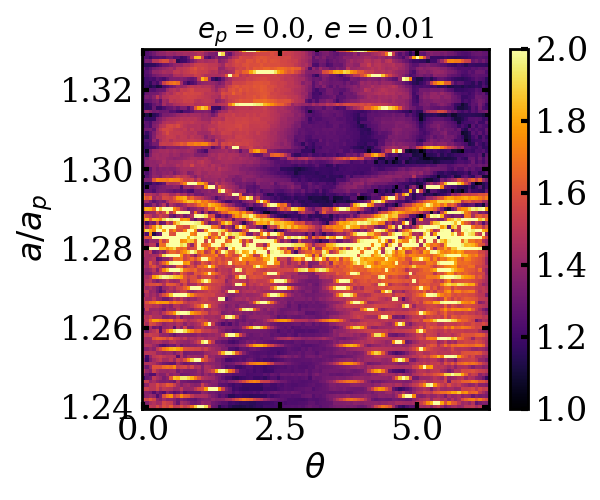

In [196]:
fig, ax = plt.subplots()
cs = ax.pcolormesh(TH2V,AV,RR,vmin=1,vmax=2,cmap="inferno")
ax.set_title(r"$e_p=$"+f"{params[e_p]}, "+r"$e=$"+f"{params["e0"]}")
ax.set_ylabel(r"$a/a_p$")
ax.set_xlabel(r"$\theta$")
plt.colorbar(cs)
fig.tight_layout()
save_to_clipboard()